## Data Story
### Instacart Market Basket Analysis EDA: Feature Set
----
Ryan Alexander Alberts

6/27/2017

#### In this notebook, I want to explore features that may drive a customer's decision strategy for their next order.

----

* __Define bounds of test set:__
    * __Products__ (for each customer)
        * all previously ordered products
        * categories for all products
        * total number of products
        * product | order_number groups
    * __Customers__
        * reorder rate (% of products w/ 'reordered' == 1)
        * order count
    * __Basket Size__
        * max, min, avg. product count per customer
        * weighted avg. product count (timeseries, frequency)
    * __'None'__
        * subset of customers|orders for which 'None' may work
        * behavior in context of 'ideal' order product count


* __Explore baseline submissions__
    * orders containing all previously ordered products
    * orders including subsets of previously ordered products 
        * based on frequency
        * based on most recent order(s)


* __Future Topics__
    * Order Frequency
    * Days since last order
    * day of the week, hour of the day
    * Macro-level trends in timeseries-data, like spikes in product count in first xx% or last xx% of all customers orders, corresonding to Summer or holidays
    * Weekday vs. Weekend
    * variability of product count across customer orders
    * [reorder > 1] --vs-- [reorder == 1 and in most recent order]
    * for last order|product: # of orders since last occurance





---


In [3]:
import pandas as pd
import re
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
import calendar

In [4]:
# First, let's import requisite files
orders      = pd.read_csv('../Instacart_Input/orders.csv')
prior_set   = pd.read_csv('../Instacart_Input/order_products__prior.csv')
train_set   = pd.read_csv('../Instacart_Input/order_products__train.csv')
aisles      = pd.read_csv('../Instacart_Input/aisles.csv')
departments = pd.read_csv('../Instacart_Input/departments.csv')
products    = pd.read_csv('../Instacart_Input/products.csv')

In [5]:
test = orders[orders['eval_set'] == 'test']
test.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
38,2774568,3,test,13,5,15,11.0
44,329954,4,test,6,3,12,30.0
53,1528013,6,test,4,3,16,22.0
96,1376945,11,test,8,6,11,8.0
102,1356845,12,test,6,1,20,30.0


In [6]:
# order history for all user_ids in test set
test_user_orders = orders[orders['user_id'].isin(test['user_id'].values)]
test_user_orders = test_user_orders.merge(prior_set, on='order_id')
test_user_orders.sort_values(by='user_id').head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,1374495,3,prior,1,1,14,NaN,9387,1,0
63,3225766,3,prior,8,0,17,7.0,47766,6,1
62,3225766,3,prior,8,0,17,7.0,21903,5,1
61,3225766,3,prior,8,0,17,7.0,18599,4,1
60,3225766,3,prior,8,0,17,7.0,43961,3,1


In [7]:
# Let's add in department and aisle data, now that we have products

products_df = pd.merge(left=pd.merge(products, right=departments, on='department_id'), 
                       right=aisles, on='aisle_id')
products_df = products_df.drop(['department_id', 'aisle_id'], axis=1)
test_user_orders = test_user_orders.merge(products_df, on='product_id')
test_user_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,department,aisle
0,1374495,3,prior,1,1,14,NaN,9387,1,0,Granny Smith Apples,produce,fresh fruits
1,2037211,3,prior,4,2,18,20.0,9387,3,1,Granny Smith Apples,produce,fresh fruits
2,2710558,3,prior,5,0,17,12.0,9387,2,1,Granny Smith Apples,produce,fresh fruits
3,1972919,3,prior,6,0,16,7.0,9387,3,1,Granny Smith Apples,produce,fresh fruits
4,1839752,3,prior,7,0,15,7.0,9387,9,1,Granny Smith Apples,produce,fresh fruits


In [8]:
# For each customer, create an array of order_ids, 
# and for each order_id, an array of products

user_orderlist = pd.DataFrame(test_user_orders.groupby('user_id')
                              ['order_id'].apply(list))
order_productlist = pd.DataFrame(test_user_orders.groupby('order_id')
                                 ['product_id'].apply(list))
user_orderlist.head()

,order_id
user_id,
3,"[1374495, 2037211, 2710558, 1972919, 1839752, ..."
4,"[3343014, 3343014, 3343014, 691089, 3343014, 2..."
6,"[2086598, 298250, 2086598, 2086598, 298250, 20..."
11,"[2411567, 2921164, 2411567, 2411567, 2840752, ..."
12,"[221248, 221248, 1916106, 1247527, 1057378, 22..."


In [9]:
# prettify dataframes
user_orderlist.reset_index(level='user_id', inplace=True)
user_orderlist.columns = ['user_id', 'orders_array']

order_productlist.reset_index(level='order_id', inplace=True)
order_productlist.columns = ['order_id', 'products_array']
order_productlist.head()

,order_id,products_array
0,13,"[41290, 196, 33198, 36086, 25952, 25783, 3800,..."
1,15,"[32463, 7461, 19660, 21195, 2996]"
2,16,"[25466, 45437, 9755]"
3,18,"[47766, 8021, 44632, 48745, 7948, 5212, 34969,..."
4,24,"[46175, 9065, 40078]"


In [10]:
# Let's add department and aisle lists for each order

order_categorylist = pd.DataFrame(test_user_orders.groupby('order_id')
                              ['department'].apply(list).apply(np.unique))
order_sub_categorylist = pd.DataFrame(test_user_orders.groupby('order_id')
                              ['aisle'].apply(list).apply(np.unique))

In [11]:
# Prettify DataFrames
order_categorylist.reset_index(level='order_id', inplace=True)
order_categorylist.columns = ['order_id', 'departments_array']

order_sub_categorylist.reset_index(level='order_id', inplace=True)
order_sub_categorylist.columns = ['order_id', 'aisles_array']
order_categorylist.head()

,order_id,departments_array
0,13,"[alcohol, beverages, dairy eggs, pantry, snacks]"
1,15,"[beverages, canned goods, pantry, personal care]"
2,16,"[beverages, snacks]"
3,18,"[babies, beverages, bulk, canned goods, dairy ..."
4,24,[frozen]


In [12]:
# Let's calculate reorder rates for each order. 
# First, we need to make the 'reordered' column more accessible

order_reorderlist = pd.DataFrame(test_user_orders.groupby('order_id')
                              ['reordered'].apply(list))
# Prettify DataFrames
order_reorderlist.reset_index(level='order_id', inplace=True)
order_reorderlist.columns = ['order_id', 'reordered_array']

order_reorderlist.head()

,order_id,reordered_array
0,13,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,15,"[1, 1, 1, 1, 1]"
2,16,"[0, 0, 1]"
3,18,"[1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, ..."
4,24,"[0, 0, 0]"


In [13]:
# Now, we can add reorder rates and product counts for each order

order_reorderlist['reorder_rate'] = 0.0
order_reorderlist['product_count'] = 0

for i in range(len(order_reorderlist)):
    reorderlist = order_reorderlist['reordered_array'][i]
    order_reorderlist.set_value(i, 'product_count', len(reorderlist))
    if 1 in reorderlist:
        order_reorderlist.set_value(i, 'reorder_rate', round(np.sum(reorderlist) / float(len(reorderlist))*100, 2))
    
order_reorderlist.tail()

,order_id,reordered_array,reorder_rate,product_count
1167492,3421076,"[1, 1, 1, 1, 1, 1, 1, 0]",87.50,8
1167493,3421077,"[0, 0, 0, 0]",0.00,4
1167494,3421078,"[1, 1, 0, 1, 1, 0, 1, 1, 1]",77.78,9
1167495,3421079,[0],0.00,1
1167496,3421083,"[1, 1, 0, 1, 1, 0, 0, 0, 0, 0]",40.00,10


In [14]:
# Let's create a master DataFrame that centralizes 
# all order data and newly minted meta-data

testgroup_priororders = orders[orders['user_id'].isin(test['user_id'].values)]
testgroup_priororders = testgroup_priororders[testgroup_priororders['eval_set'] == 'prior']

master_orders_df = pd.merge(testgroup_priororders, 
                            pd.merge(order_reorderlist, 
                                     order_productlist, 
                                     on='order_id'), 
                            on='order_id')
master_orders_df = pd.merge(master_orders_df, pd.merge(order_sub_categorylist, 
                                                       order_categorylist, 
                                                       on='order_id'), 
                            on='order_id')
master_orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,reordered_array,reorder_rate,product_count,products_array,aisles_array,departments_array
0,1374495,3,prior,1,1,14,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.00,10,"[9387, 17668, 15143, 16797, 39190, 47766, 2190...","[crackers, fresh fruits, packaged vegetables f...","[dairy eggs, produce, snacks]"
1,444309,3,prior,2,3,19,9.0,"[1, 1, 1, 0, 0, 0, 0, 0, 0]",33.33,9,"[17668, 21903, 32402, 38596, 248, 40604, 8021,...","[crackers, fresh fruits, nuts seeds dried frui...","[beverages, dairy eggs, household, produce, sn..."
2,3002854,3,prior,3,3,16,21.0,"[1, 1, 1, 0, 0, 0]",50.00,6,"[39190, 47766, 21903, 49683, 28373, 7503]","[fresh fruits, fresh vegetables, nuts seeds dr...","[dairy eggs, deli, produce, snacks]"
3,2037211,3,prior,4,2,18,20.0,"[1, 0, 0, 0, 0]",20.00,5,"[9387, 1819, 12845, 16965, 24010]","[fresh fruits, frozen breakfast, ice cream ice...","[frozen, pantry, produce, snacks]"
4,2710558,3,prior,5,0,17,12.0,"[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]",63.64,11,"[9387, 17668, 39190, 47766, 21903, 28373, 1696...","[fresh fruits, fresh vegetables, ice cream ice...","[dairy eggs, deli, frozen, produce]"


In [15]:
# Complete list of previously purchased products for each user 
# (includes duplicates!)
user_products = pd.DataFrame(test_user_orders.groupby('user_id')['product_id'].size())

# Prettify DataFrame
user_products.reset_index(level='user_id', inplace=True)
user_products.columns = ['user_id', 'total_products']

# Add total number of orders & averages
temp = orders[orders['user_id'].isin(test['user_id'].values)]
temp = temp[temp['eval_set'] == 'prior']

user_orders_meta = pd.DataFrame(temp.loc[:,('user_id', 'order_number')].groupby(['user_id']).size()).reset_index()
user_orders_meta = user_orders_meta.merge(user_products, on='user_id')

# Prettify DataFrame
user_orders_meta.columns = ['user_id', 'total_orders', 'total_products']

user_orders_meta['avg_products_per_order'] = (user_orders_meta['total_products'] / user_orders_meta['total_orders'])
user_orders_meta.head(10)

,user_id,total_orders,total_products,avg_products_per_order
0,3,12,88,7.333333
1,4,5,18,3.600000
2,6,3,14,4.666667
3,11,7,94,13.428571
4,12,5,74,14.800000
5,15,22,72,3.272727
6,16,6,70,11.666667
7,19,9,204,22.666667
8,20,4,22,5.500000
9,22,15,69,4.600000


In [16]:
# Lists of products and order frequency for each user
customer_product_counts = pd.DataFrame(test_user_orders.groupby('user_id')
                                       ['product_id'].value_counts())
# Prettify DataFrame
customer_product_counts.columns = ['order_instances']

customer_product_counts.head(35)

order_instances
user_id product_id                 
3       39190                    10
        47766                     9
        21903                     8
        9387                      5
        17668                     5
        18599                     4
        43961                     4
        1819                      3
        16797                     3
        22035                     3
        24810                     3
        32402                     3
        14992                     2
        16965                     2
        23650                     2
        24010                     2
        28373                     2
        44683                     2
        48523                     2
        248                       1
        1005                      1
        7503                      1
        8021                      1
        12845                     1
        15143                     1
        18370                     1
        21137                     1
        38596                     1
        39922                     1
        40604                     1
        42265                     1
        42557                     1
        49683                     1
4       35469                     2
        1200                      1

In [18]:
# For each user, groups of order_numbers associated with each product_id
customer_orders_assortment = pd.DataFrame(test_user_orders.groupby(['user_id', 'product_id'])
                                       ['order_number'].value_counts())
# Prettify DataFrame
customer_orders_assortment = customer_orders_assortment.drop(['order_number'], axis=1)

customer_orders_assortment.head(15)

Empty DataFrame
Columns: []
Index: [(3, 248, 2), (3, 1005, 10), (3, 1819, 4), (3, 1819, 6), (3, 1819, 7), (3, 7503, 3), (3, 8021, 2), (3, 9387, 1), (3, 9387, 4), (3, 9387, 5), (3, 9387, 6), (3, 9387, 7), (3, 12845, 4), (3, 14992, 6), (3, 14992, 7)]

In [19]:
# The above DataFrame is visually appealing, 
# but I'll update it for easier data manipulation

customer_orders_assortment = customer_orders_assortment.reset_index()
customer_orders_assortment.head(15)

,user_id,product_id,order_number
0,3,248,2
1,3,1005,10
2,3,1819,4
3,3,1819,6
4,3,1819,7
5,3,7503,3
6,3,8021,2
7,3,9387,1
8,3,9387,4
9,3,9387,5


In [205]:
# Let's add product inclusion rates

# Some setup required
customer_orders_assortment['product_inclusion_rate'] = 0.0
user_temp_list = np.unique(customer_orders_assortment['user_id'])
#new = pd.DataFrame()

for i in user_temp_list[65053:]:
    user_df = customer_orders_assortment[customer_orders_assortment['user_id'] == [i]]
    for x in user_df.index.values:
        user_df.set_value(x, 
                          'product_inclusion_rate', 
                          (user_df[user_df['product_id'] == user_df['product_id'][x]]['product_id'].count() / float(user_df['order_number'].max())
                          )
                         )
    if len(new) < len(user_df): 
        new = user_df
    else:
        new = pd.concat([new, user_df])
new

,user_id,product_id,order_number,product_inclusion_rate
0,3,248,2,0.083333
1,3,1005,10,0.083333
2,3,1819,4,0.250000
3,3,1819,6,0.250000
4,3,1819,7,0.250000
5,3,7503,3,0.083333
6,3,8021,2,0.083333
7,3,9387,1,0.416667
8,3,9387,4,0.416667
9,3,9387,5,0.416667


count    12.000000
mean      7.333333
std       2.103388
min       5.000000
25%       5.750000
50%       7.000000
75%       9.000000
max      11.000000
Name: order_number, dtype: float64

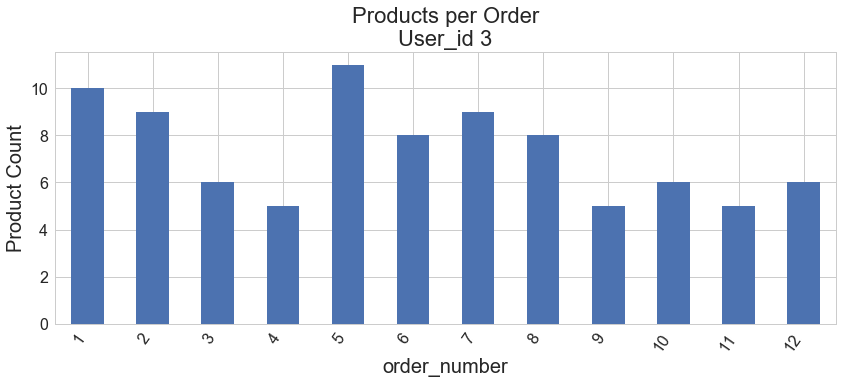

In [345]:
# let's jump into user_id 3 to explore trends in order behavior
# Let's start with product counts across orders

user_3_count = new[new['user_id'] == 3]['order_number'].value_counts().sort_index()

f, ax = plt.subplots(figsize=(14,5), ncols=1)

user_3_count.plot(kind='bar')
_= ax.set_title('Products per Order\nUser_id 3', size=22)
_= ax.set_ylabel('Product Count', size=20)
_= ax.set_xlabel('order_number', size=20)
_= ax.tick_params(labelsize=16)
plt.xticks(ha='right', rotation=55);
user_3_count.describe()

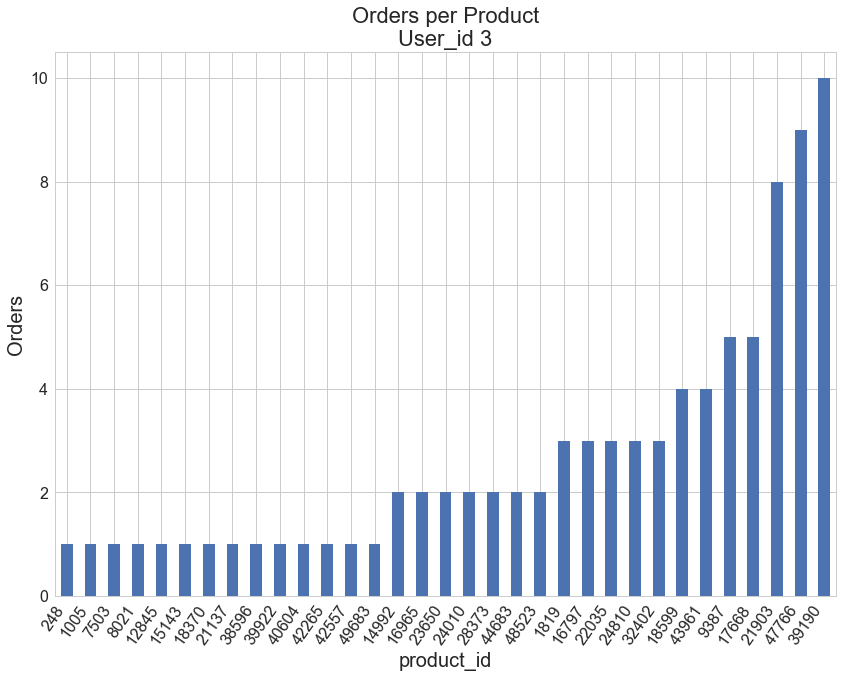

In [321]:
# Now, let's check out how individual products compare in terms of frequency of reorder. 

user_3 = new[new['user_id'] == 3].groupby(['product_inclusion_rate', 
                                         'product_id'
                                        ]).size()
f, ax = plt.subplots(figsize=(14,10), ncols=1)

user_3.plot(kind='bar')
_= ax.set_title('Orders per Product\nUser_id 3', size=22)
_= ax.set_ylabel('Order Count', size=20)
_= ax.set_xlabel('product_id', size=20)
_= ax.tick_params(labelsize=16)
plt.xticks(range(len(user_3)), user_3.index.get_level_values(level=1), ha='right', rotation=55);

#### Observations:
1. There is an initial period of experimentation, categorized by:
    * higher drop-off in product count
    * lower reorder rates for particular products
2. Then, there is a stabilization period, categorized by:
    * product count approaching the mean as order_number increases
    * as order_number increases, so does product_inclusion_rate for top performing products
3. General thoughts:
    * there is a long-tail of once-ordered products.


### Summary

#### We now have:
1. Slightly overwhelming DataFrame with complete order history for test users [test_user_orders]

#### For each test-user's orders:
2. More approachable DataFrames, including:
      1.                                   product lists
      2.                                   product counts 
      3.                                   departments lists  
      4.                                   aisle lists
      5.                                   reorder rates
      6.                                   average product counts


#### And for each test-user: 
3. More approachable DataFrames, including:
      1. order lists [useful for variability]
      2. product lists [useful for basket sizing]
      2. product order frequency
      3. total product counts
      4. product | order_number groups [useful for frequency, cyclicality, variability]
      5. product inclusion rates (% of total orders in which a product was included)

In [207]:
#new1.to_csv('inclusion_rate.csv', index=False)